<a href="https://colab.research.google.com/github/AllerLydia/Deep-Learning/blob/master/02_nn_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_circles


In [2]:
n_sample = 1000
X, y = make_circles(n_sample,
                    noise = 0.02,
                    random_state=42)

In [3]:
X[:5], y[:5]

(array([[ 0.76026594,  0.22387823],
        [-0.76722217,  0.1455425 ],
        [-0.80815854,  0.14894355],
        [-0.3760283 ,  0.70320906],
        [ 0.44051035, -0.89761737]]), array([1, 1, 1, 1, 0]))

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.760266,0.223878,1
1,-0.767222,0.145542,1
2,-0.808159,0.148944,1
3,-0.376028,0.703209,1
4,0.440510,-0.897617,0


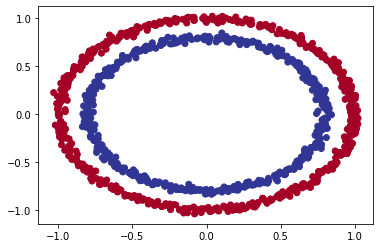

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]

In [8]:
X_sample, y_sample

(array([0.76026594, 0.22387823]), 1)

In [9]:
import torch
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
x[:5], y[:5]

(tensor([[ 0.7603,  0.2239],
         [-0.7672,  0.1455],
         [-0.8082,  0.1489],
         [-0.3760,  0.7032],
         [ 0.4405, -0.8976]]), tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2,
                                                    random_state=42)

In [12]:
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
import torch
from torch import nn

In [15]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_0 = CircleModelv1().to(device)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
#repulicate with nn.sequencial

model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[-2.5802e-04, -1.6886e-01],
                      [ 4.2006e-01,  5.1963e-01],
                      [-2.0112e-01,  6.3954e-01],
                      [ 4.8408e-01, -1.9998e-01],
                      [-7.3147e-02,  4.3178e-01]])),
             ('layer_1.bias',
              tensor([ 0.1741, -0.0852,  0.0918, -0.6210,  0.1046])),
             ('layer_2.weight',
              tensor([[-0.2563,  0.3504, -0.3584, -0.3256,  0.0745]])),
             ('layer_2.bias', tensor([-0.0311]))])

In [19]:
with torch.inference_mode():
  untrained_preds = model_0(x_test.to(device))
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [20]:
untrained_preds[:10]

tensor([[0.1143],
        [0.1621],
        [0.0017],
        [0.1442],
        [0.0274],
        [0.0554],
        [0.1711],
        [0.1454],
        [0.0039],
        [0.1665]])

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), 
                            lr = 0.1)

In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred))* 100
  return acc

In [23]:
torch.manual_seed=42
epochs = 100

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, 
                 y_train)
  
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    
    test_acc = accuracy_fn(y_test, 
                           test_pred)
  
  if epochs & 10 == 0:
    print(f"Epoch: {epoch} |loss: {loss:.5f} | Acc: {acc:.2f}")

Epoch: 0 |loss: 0.69373 | Acc: 54.75
Epoch: 1 |loss: 0.69367 | Acc: 54.50
Epoch: 2 |loss: 0.69362 | Acc: 54.12
Epoch: 3 |loss: 0.69357 | Acc: 54.12
Epoch: 4 |loss: 0.69353 | Acc: 53.50
Epoch: 5 |loss: 0.69349 | Acc: 53.87
Epoch: 6 |loss: 0.69345 | Acc: 53.62
Epoch: 7 |loss: 0.69342 | Acc: 53.37
Epoch: 8 |loss: 0.69339 | Acc: 53.12
Epoch: 9 |loss: 0.69336 | Acc: 52.88
Epoch: 10 |loss: 0.69334 | Acc: 52.88
Epoch: 11 |loss: 0.69332 | Acc: 52.50
Epoch: 12 |loss: 0.69329 | Acc: 52.62
Epoch: 13 |loss: 0.69328 | Acc: 52.38
Epoch: 14 |loss: 0.69326 | Acc: 52.38
Epoch: 15 |loss: 0.69324 | Acc: 52.12
Epoch: 16 |loss: 0.69323 | Acc: 51.88
Epoch: 17 |loss: 0.69321 | Acc: 52.00
Epoch: 18 |loss: 0.69320 | Acc: 51.88
Epoch: 19 |loss: 0.69319 | Acc: 52.00
Epoch: 20 |loss: 0.69318 | Acc: 52.12
Epoch: 21 |loss: 0.69317 | Acc: 51.88
Epoch: 22 |loss: 0.69316 | Acc: 52.00
Epoch: 23 |loss: 0.69315 | Acc: 52.12
Epoch: 24 |loss: 0.69314 | Acc: 52.12
Epoch: 25 |loss: 0.69314 | Acc: 52.50
Epoch: 26 |loss: 0.693

In [24]:
# build model with non-linear function

In [25]:
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelv2().to(device)

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

In [27]:
torch.manual_seed=42

In [28]:
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

epochs = 200

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    
  if epoch % 10 == 0:
    print(f"Loss is: {loss:.4f} | test loss is: {test_loss:.4f} | accuracy: {acc:.3f}")


Loss is: 0.6916 | test loss is: 0.6916 | accuracy: 50.000
Loss is: 0.6912 | test loss is: 0.6912 | accuracy: 50.000
Loss is: 0.6908 | test loss is: 0.6909 | accuracy: 50.750
Loss is: 0.6904 | test loss is: 0.6905 | accuracy: 52.875
Loss is: 0.6901 | test loss is: 0.6904 | accuracy: 53.125
Loss is: 0.6899 | test loss is: 0.6902 | accuracy: 53.125
Loss is: 0.6896 | test loss is: 0.6900 | accuracy: 53.625
Loss is: 0.6894 | test loss is: 0.6898 | accuracy: 54.625
Loss is: 0.6891 | test loss is: 0.6896 | accuracy: 54.750
Loss is: 0.6889 | test loss is: 0.6895 | accuracy: 55.625
Loss is: 0.6886 | test loss is: 0.6893 | accuracy: 55.875
Loss is: 0.6884 | test loss is: 0.6891 | accuracy: 56.000
Loss is: 0.6881 | test loss is: 0.6889 | accuracy: 56.750
Loss is: 0.6878 | test loss is: 0.6887 | accuracy: 57.125
Loss is: 0.6875 | test loss is: 0.6886 | accuracy: 57.500
Loss is: 0.6872 | test loss is: 0.6883 | accuracy: 57.750
Loss is: 0.6869 | test loss is: 0.6881 | accuracy: 58.125
Loss is: 0.686

In [29]:
# >>> x = torch.zeros(2, 1, 2, 1, 2)
# >>> x.size()
# torch.Size([2, 1, 2, 1, 2])
# >>> y = torch.squeeze(x)
# >>> y.size()
# torch.Size([2, 2, 2])
# >>> y = torch.squeeze(x, 0)
# >>> y.size()
# torch.Size([2, 1, 2, 1, 2])
# >>> y = torch.squeeze(x, 1)
# >>> y.size()
# torch.Size([2, 2, 1, 2])

In [30]:
x = torch.zeros(2, 1, 2, 1, 2)

In [31]:
x.squeeze()

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

In [32]:
A = torch.arange(-10.0, 10.0, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

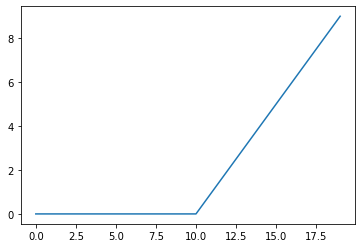

In [33]:
plt.plot(torch.relu(A))

In [34]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [35]:
# Multiclass classification

In [81]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size = 0.2, random_state=RANDOM_SEED)

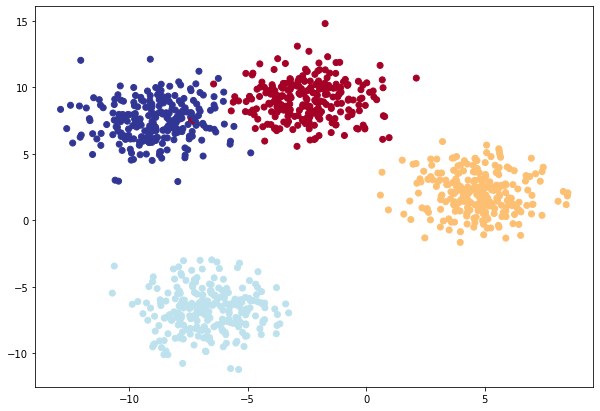

In [82]:
plt.figure(figsize = (10, 7))
plt.scatter(x_blob[:,0], x_blob[:,1],c=y_blob, cmap = plt.cm.RdYlBu)

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [108]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Linear(in_features=hidden_units, out_features = output_features)
    
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units=8).to(device)

In [109]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [118]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)

In [111]:
#model_4.eval()
#with torch.inference_mode():
#  y_logits = model_4(x_blob_test.to(device))

#y_logits[:10]

In [123]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [112]:
#y_pred_probs = torch.softmax(y_logits, dim = 1)

In [113]:
#y_preds = torch.argmax(y_pred_probs, dim = 1)

In [114]:
#y_preds.shape

In [115]:
#y_blob_test.shape

In [120]:
torch.manual_seed = 42

epochs = 100

x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)


for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_preds)
    
  if epoch % 10 == 0:
    print(f"epoch : {epoch} | loss | {loss:.4f} | accuracy {acc:.3f} | test loss {test_loss:.4}  | test accuracy {test_acc:.4f}")

epoch : 0 | loss | 0.0313 | accuracy 99.250 | test loss 0.02279  | test accuracy 99.5000
epoch : 10 | loss | 0.0303 | accuracy 99.250 | test loss 0.02155  | test accuracy 99.5000
epoch : 20 | loss | 0.0294 | accuracy 99.250 | test loss 0.02054  | test accuracy 99.5000
epoch : 30 | loss | 0.0287 | accuracy 99.250 | test loss 0.0197  | test accuracy 99.5000
epoch : 40 | loss | 0.0281 | accuracy 99.250 | test loss 0.01898  | test accuracy 99.5000
epoch : 50 | loss | 0.0276 | accuracy 99.250 | test loss 0.01837  | test accuracy 99.5000
epoch : 60 | loss | 0.0272 | accuracy 99.250 | test loss 0.01784  | test accuracy 99.5000
epoch : 70 | loss | 0.0268 | accuracy 99.250 | test loss 0.01738  | test accuracy 99.5000
epoch : 80 | loss | 0.0265 | accuracy 99.250 | test loss 0.01697  | test accuracy 99.5000
epoch : 90 | loss | 0.0262 | accuracy 99.250 | test loss 0.0166  | test accuracy 99.5000


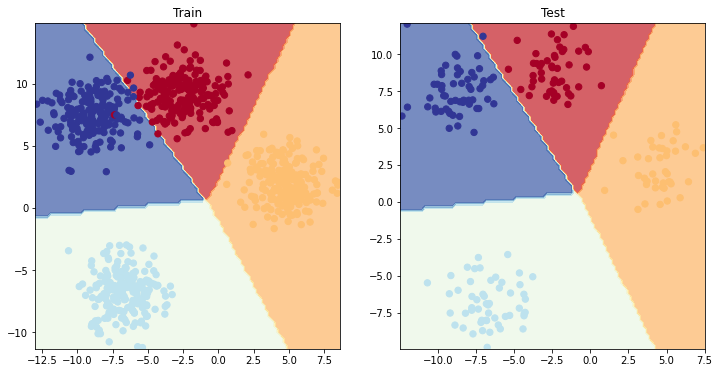

In [125]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)